In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

In [44]:
class Node:
    def __init__(self, i, val, dist):
        self.id = i
        self.val = np.array(val)
        self.dist = dist
        
        self.child = []
        self.depth = 0
        self.degree = 0
        self.parent = None
        self.angle = 0
        self.dist_from_parent = 0
        
    def addChild(self, child):
        self.child.append(child)
        self.degree += 1
    def setParent(self, parent):
        self.parent = parent
        self.setAngleWithVertical()
        self.setDistFromParent()
        
    def setAngleWithVertical(self):
        temp = self.val - self.parent.val
        self.angle = np.rad2deg(np.arccos(np.dot(temp, np.array([0, 0, 1]))/np.linalg.norm(temp)))
    
    def setDistFromParent(self):
        self.dist_from_parent = np.linalg.norm(self.val-self.parent.val)

In [45]:
def initialize_graph(filename):
    f = open(filename, "r", newline="\n")
    t = f.readlines()
    #print(t[2].split("\n")[0])
    
    n = list(eval(t[0].split("\n")[0]))
    e = list(eval(t[1].split("\n")[0]))
    d = dict(eval(t[2].split("\n")[0]))
    nodes = dict()
    encoding = dict()

    
    for i, v in enumerate(n):
        nodes[i] = Node(i, v, d[v])
        encoding[v] = i
        
    for (par, chd) in e:
        p = encoding[par]
        c = encoding[chd]
        nodes[p].addChild(nodes[c])
        nodes[c].setParent(nodes[p])
        ''' 
        nodes[p].degree += 1
        nodes[c].degree += 1
        '''
        nodes[c].depth = nodes[p].depth + 1
        
        
    root = nodes[0]
    
    return root, nodes, encoding

In [108]:
def getAngle(vec1, vec2):
    return np.rad2deg(np.arccos(np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))))

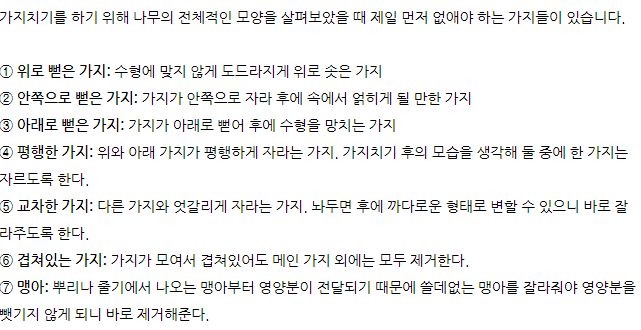

### tree.obj (simple tree)

In [109]:
root, nodes, encoding = initialize_graph('result3d.txt')

In [110]:
len(nodes)

72

In [111]:
# Function to minimize
def fitness(X):
    #print(len(X))
    queue = [root]
    penalty = 0
    n = len(X)
    visit = 0
    max_depth = max(list(map(lambda x:nodes[x].depth, nodes)))
    max_dist = max(list(map(lambda x:nodes[x].dist_from_parent, nodes)))
    
    while queue:
        current = queue.pop(0)
        visit += 1
    
        for child in current.child:
            if X[child.id] != 0:
                queue.append(child)

        # 수직선과의 각도
        if current.angle and current.parent:
            #1 & 3. Trend와 맞지 않는 branches
            # (부모와 부모의 부모 노드 사이 벡터)와 (부모와 현재 노드 사이 벡터) 사이의 각도
            # 노드가 현재 나뭇가지가 자라는 trend와 다르다면 penalty
            if current.parent.parent:
                cur_to_parent = current.val - current.parent.val
                parent_to_parent = current.parent.val - current.parent.parent.val
                angle = getAngle(cur_to_parent, parent_to_parent)
                
                if angle > 150:
                    counts["trend"] += 1
                    penalty += 1/n
                    
        # 4. 평행한 가지
        if current.child:
            if len(current.child) > 1:
                current_to_childs = []
                for child in current.child:
                    current_to_childs.append(child.val-current.val)
                
                for i in range(len(current_to_childs)):
                    for j in range(i+1, len(current_to_childs)):
                        if getAngle(current_to_childs[i], current_to_childs[j]) < 5:
                            counts["parallel"] += 1
                            penalty += 1/n

        # degree
        if current.degree >= 10:
            counts["degree"] += 1/n
            penalty += 1
        
        if current.depth > max_depth * 0.9:
            counts["depth"] += 1/n
            penalty += 1
            
        if current.angle > 90:
            counts["angle"] += 1/n
            penalty += 1
            
        if current.dist_from_parent > max_dist * 0.9:
            counts["distance"] += 1
            penalty += 1/n
        
    return -visit + penalty

__________________________________________________ 0.3% GA is running...

<ipython-input-108-df0af862a8b3>:2: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))))


 The best solution found:                                                                           
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1.]

 Objective function:
 -40.986111111111114


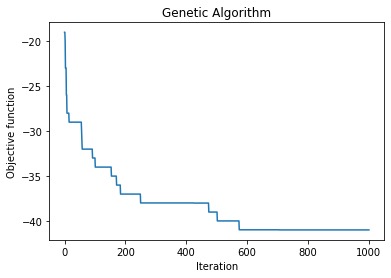

In [112]:
counts = {"trend":0, "parallel":0, "degree":0, "depth":0, "angle":0, "distance":0}

algorithm_param = {'max_num_iteration':1000,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':500}

model=ga(function=fitness, dimension=len(nodes), variable_type='bool', algorithm_parameters=algorithm_param)

model.run()

In [113]:
chromosome = model.output_dict['variable']
print(chromosome)
print(counts)

[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1.]
{'trend': 0, 'parallel': 0, 'degree': 0, 'depth': 413.00000000023545, 'angle': 7820.763888808094, 'distance': 23960}


In [114]:
visit = []
queue = [root]

while queue:
    current = queue.pop(0)
    
    if current.id not in visit:
        visit.append(current.id)
        
        for child in current.child:
            if chromosome[child.id] != 0:
                queue.append(child)
            

ch=np.zeros(len(chromosome))
ch[visit]=1
temp = ch

In [115]:
sum(chromosome), sum(temp)

(59.0, 57.0)

In [116]:
%matplotlib inline

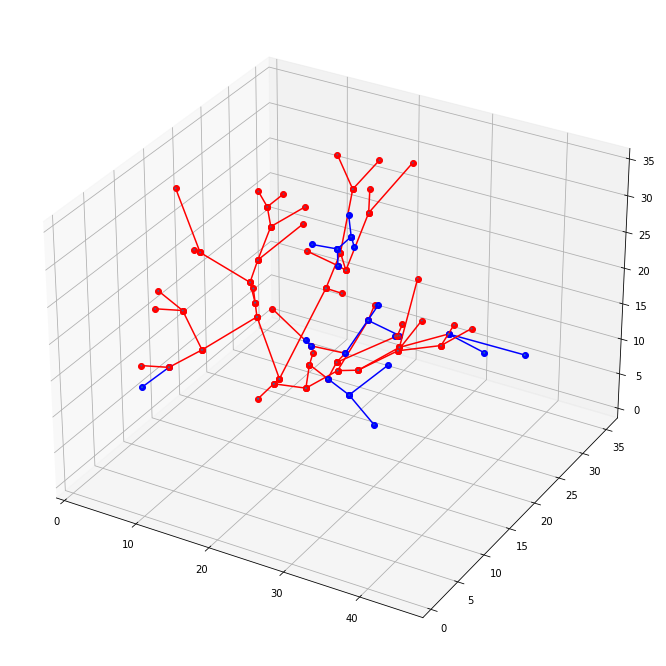

In [117]:
import matplotlib.pyplot as plt
import networkx as nx
import json
import ast

def prunedPlot():
    result = nx.DiGraph()
    
    q = [root]
    visited = []
    
    while q:
        curr = q.pop(0)
        if curr not in visited:
            q.extend(curr.child)
            visited.append(curr)
            
            result.add_node(tuple(curr.val))
            
            for child in curr.child:
                result.add_edge(tuple(curr.val), tuple(child.val))
            
    x, y, z = [], [], []
    for node in result.nodes:
        x.append(node[0])
        y.append(node[1])
        z.append(node[2])
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z, s=1)

    for node1, node2 in result.edges:
        x = [node1[0], node2[0]]
        y = [node1[1], node2[1]]
        z = [node1[2], node2[2]]
        if temp[encoding[node1]] == 0 or temp[encoding[node2]] == 0:
            ax.plot(x, y, z, 'bo-')
            pass
        
        else:
            ax.plot(x, y, z, 'ro-')

    plt.show()


prunedPlot()

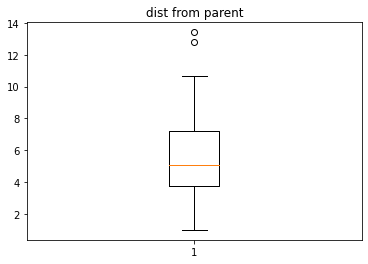

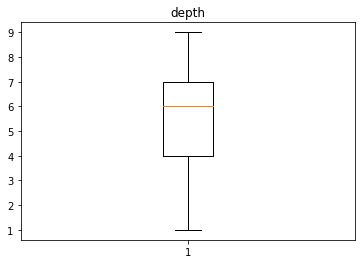

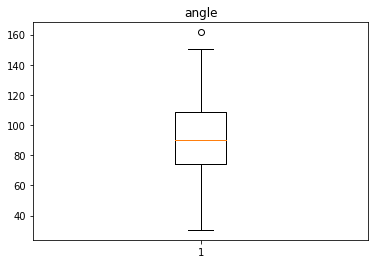

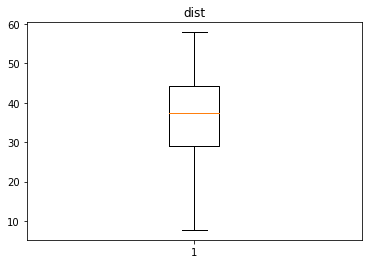

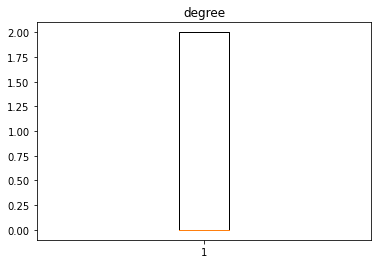

In [118]:
import matplotlib.pyplot as plt
dist_from_par = []
depth = []
angle = []
dist = []
degree = []
def boxplot():
    for i in nodes:s
        curr = nodes[i] 
        if curr != root:
            dist_from_par.append(curr.dist_from_parent)
            depth.append(curr.depth)
            angle.append(curr.angle)
            dist.append(curr.dist)
            degree.append(curr.degree)
    
    plt.figure(1)
    plt.title("dist from parent")
    plt.boxplot(dist_from_par)
    plt.figure(2)
    plt.title("depth")
    plt.boxplot(depth)
    plt.figure(3)
    plt.title("angle")
    plt.boxplot(angle)
    plt.figure(4)
    plt.title("dist")
    plt.boxplot(dist)
    plt.figure(5)
    plt.title("degree")
    plt.boxplot(degree)

    
boxplot()

### tree_hard

In [98]:
root, nodes, encoding = initialize_graph('result3d-1.txt')

In [99]:
len(nodes)

1899

<ipython-input-97-ceb051b36994>:3: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))))


 The best solution found:                                                                           
 [0. 1. 1. ... 1. 1. 1.]

 Objective function:
 -265.9915745129015


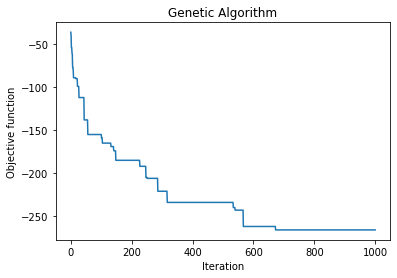

In [100]:
counts = {"trend":0, "parallel":0, "degree":0, "depth":0, "angle":0, "distance":0}

algorithm_param = {'max_num_iteration':1000,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':500}

model=ga(function=fitness, dimension=len(nodes), variable_type='bool', algorithm_parameters=algorithm_param)

model.run()

In [101]:
chromosome = model.output_dict['variable']
print(chromosome)
print(counts)

[0. 1. 1. ... 1. 1. 1.]
{'trend': 143782, 'parallel': 45661, 'degree': 74.82411795703744, 'depth': 0.02948920484465512, 'angle': 1450.8699315785852, 'distance': 201624}


In [102]:
visit = []
queue = [root]

while queue:
    current = queue.pop(0)
    
    if current.id not in visit:
        visit.append(current.id)
        
        for child in current.child:
            if chromosome[child.id] != 0:
                queue.append(child)
            

ch=np.zeros(len(chromosome))
ch[visit]=1
temp = ch

In [103]:
sum(chromosome), sum(temp)

(1030.0, 380.0)

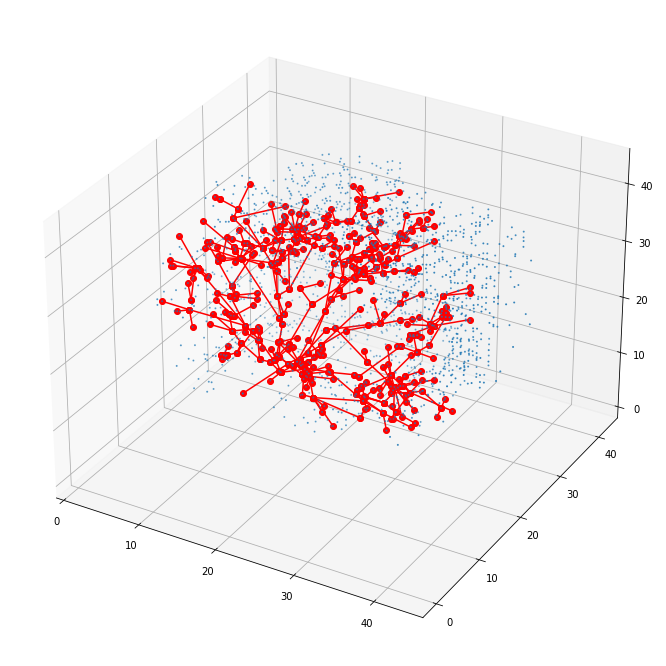

In [106]:
import matplotlib.pyplot as plt
import networkx as nx
import json
import ast

def prunedPlot():
    result = nx.DiGraph()
    
    q = [root]
    visited = []
    
    while q:
        curr = q.pop(0)
        if curr not in visited:
            q.extend(curr.child)
            visited.append(curr)
            
            result.add_node(tuple(curr.val))
            
            for child in curr.child:
                result.add_edge(tuple(curr.val), tuple(child.val))
            
    x, y, z = [], [], []
    for node in result.nodes:
        x.append(node[0])
        y.append(node[1])
        z.append(node[2])
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z, s=1)

    for node1, node2 in result.edges:
        x = [node1[0], node2[0]]
        y = [node1[1], node2[1]]
        z = [node1[2], node2[2]]
        if temp[encoding[node1]] == 0 or temp[encoding[node2]] == 0:
#             ax.plot(x, y, z, 'bo-')
            pass
        
        else:
            ax.plot(x, y, z, 'ro-')

    plt.show()


prunedPlot()

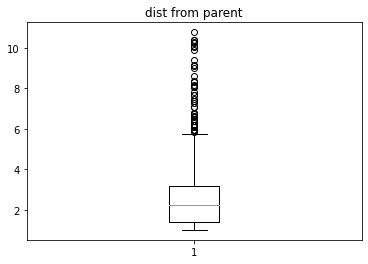

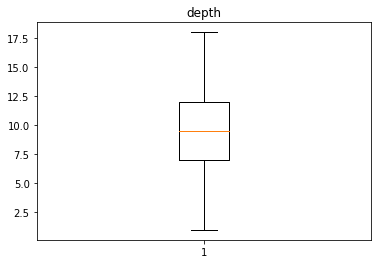

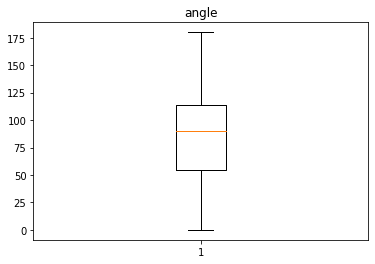

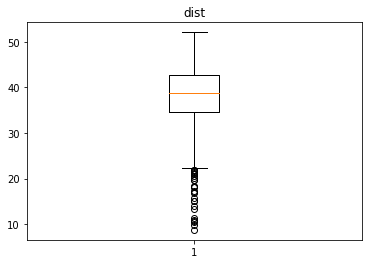

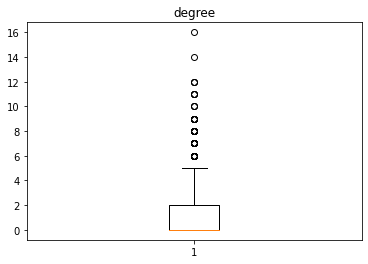

In [107]:
import matplotlib.pyplot as plt
dist_from_par = []
depth = []
angle = []
dist = []
degree = []
def boxplot():
    for i in nodes:
        curr = nodes[i] 
        if curr != root:
            dist_from_par.append(curr.dist_from_parent)
            depth.append(curr.depth)
            angle.append(curr.angle)
            dist.append(curr.dist)
            degree.append(curr.degree)
    
    plt.figure(1)
    plt.title("dist from parent")
    plt.boxplot(dist_from_par)
    plt.figure(2)
    plt.title("depth")
    plt.boxplot(depth)
    plt.figure(3)
    plt.title("angle")
    plt.boxplot(angle)
    plt.figure(4)
    plt.title("dist")
    plt.boxplot(dist)
    plt.figure(5)
    plt.title("degree")
    plt.boxplot(degree)

    
boxplot()

# 참고
* https://github.com/DEAP/deap